# Energetics of the EN4 dataset

Aim: The main aim of this analysis is to investigate how the excess of energy taken up by the oceans affect the heat versus the APE

In [1]:
import numpy as np
import numpy.ma as ma
import gsw
from gsw_gammat_analytic_CT_exact import *
from gsw_gammat_analytic_CT_fast import *
from gsw_gammat_analytic_CT import *
import time
import os
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import netCDF4 as nc4
import seaborn as sns
sns.set_context('paper')
palette = sns.color_palette("gnuplot", 3)
sns.set_theme(context='paper', style='dark', palette=palette,rc={'xtick.bottom': True,'ytick.left': True})



In [2]:
# Define analytical Lorenz reference density profile
# --------------------------------------------------
# Set values of coefficients
# --------------------------------------------------
a = 4.56016575
b = -1.24898501
c = 0.00439778209
d = 1030.99373
e = 8.32218903 

# Define gravity 
grav = 9.81

# Define analytical expressions for reference density and pressure
# ----------------------------------------------------------------
rhor = lambda z: a/(b+1)*(z+e)**(b+1) + c*z + d  ## This analytical density profile fitted on the WOCE dataset.
pr = lambda z: grav * (a/((b+1)*(b+2))*((z+e)**(b+2)) + c/2.*z**2 + d*z - a/((b+1)*(b+2))*e**(b+2))/1e4

filtIO = np.load('IO_filter.npy', allow_pickle = True)
filtPO = np.load('PO_filter.npy', allow_pickle = True)



In [3]:
# Locate the data and define rules for constructing data file names
# datadir = 'C:\Users\Linne\Documents\Github\APE-Estimates\Data'
# datadir = '/Users/remitailleux/Documents/DATASETS/EN4_DATA'
rootname = 'EN.4.2.2.f.analysis.g10.'

# Open a random file to extract relevant information and put the info into 'data' 
data = xr.open_dataset(f'Data/{rootname}195001.nc')
# fields = nc4.Dataset(f'{datadir}/{1950}/{rootname}195001.nc')


# Upload depth bounds and compute layer thickness
ZB = data.depth_bnds.to_numpy().squeeze() 
# ZB = fields.variables['depth_bnds'][:]
e3t = ZB[:,1] - ZB[:,0]
print(e3t.shape)
print(e3t) 

# Upldate longitude, latitude, and depths of temperature points
lon1D = data.lon.to_numpy()
# lon1D = fields.variables['lon'][:]
npi = len(lon1D)
lat1D = data.lat.to_numpy()
# lat1D = fields.variables['lat'][:]
npj = len(lat1D) 
z1D = data.depth.to_numpy() 
# z1D = fields.variables['depth'][:]
npk = len(z1D) 
print([npk,npj,npi])

# load practical salinity, primarily to get the mask
SP = data.salinity.to_masked_array().squeeze()

# Define 3D version of depths and compute the reference pressure
z3d = np.zeros([npk,npj,npi]) 
for k in range(0,npk):
    z3d[k, :, :] = z1D[k] 
prz = pr(z3d) 

# Compare horizontal area for each elements
ra = 6.371e6
dx = ra*(lon1D[1]-lon1D[0])*np.pi/180
print(f'length of dx={dx}')

#area = np.empty((npi,npj)) 
#area[:] = ra*dx*(np.sin((lat1D[:]+0.5)*np.pi/180) - np.sin((lat1D[:]-0.5)*np.pi/180))
#print(area.shape) 
#area = np.transpose(area) 
#print(area.shape) 

area = ra*dx*(np.sin((lat1D[:]+0.5)*np.pi/180) - np.sin((lat1D[:]-0.5)*np.pi/180))*np.ones(npi)[:,np.newaxis]
print(area.shape)
print(np.sum(area))

# Compute volume
dV = area.T*e3t[:, np.newaxis, np.newaxis]
print(np.sum(dV)) 

V_ijk = ma.array(dV,mask = SP.mask)
print(ma.sum(V_ijk))
V_total = ma.sum(V_ijk)
weights = V_ijk/V_total
print([V_total,ma.sum(weights)])

print(weights.shape)

# Define cp0
cp0 = gsw.energy.enthalpy(35.,20.,0.)/20.
print([cp0,3991.86795711963])

(42,)
[ 10.0475    10.068301  10.0982    10.1413    10.2033    10.292297
  10.420204  10.604195  10.868401  11.247604  11.791199  12.569702
  13.682297  15.267395  17.516998  20.690811  25.132095  31.276794
  39.645218  50.8013    65.25928   83.32501  104.900696 129.3208
 155.3393   181.33575  205.69604  227.18677  245.15869  259.526
 270.6034   278.90747  285.0017   289.40527  292.5515   294.78076
 296.3518   297.45386  298.2256   298.76416  299.13965  299.40137 ]
[42, 173, 360]
length of dx=111194.92664455873
(360, 173)
508415367427200.0
2.7962845208496005e+18
1.5142117733078182e+18
[1.5142117733078182e+18, 1.0]
(42, 173, 360)
[3991.86795711963, 3991.86795711963]


# Temporal Loop

In [5]:
# Define month strings
months = ['01','02','03','04','05','06','07','08','09','10','11','12']

# Define starting and end year
start_year = 1960
end_year = 2020 
npoints = (end_year-start_year + 1)*12
ncounter = 0

CT_mean_time_series = np.zeros(npoints)
CT_IO_mean_time_series = np.zeros(npoints)
CT_PO_mean_time_series = np.zeros(npoints)

PT_mean_time_series = np.zeros(npoints)
PT_IO_mean_time_series = np.zeros(npoints)
PT_PO_mean_time_series = np.zeros(npoints)

CTR_mean_time_series = np.zeros(npoints)
CTR_IO_mean_time_series = np.zeros(npoints)
CTR_PO_mean_time_series = np.zeros(npoints)

APE_mean_time_series = np.zeros(npoints)
APE_IO_mean_time_series = np.zeros(npoints)
APE_PO_mean_time_series = np.zeros(npoints)

APE_bis_time_series = np.zeros(npoints) 
APE_negative_time_series = np.zeros(npoints)

# Start of temporal loop 

for year in range(start_year,end_year+1):
    decade = (year//10)*10  
    for month in months:
        print(ncounter) 
        
        start = time.time()
        
        # define filename and open the data set using xarray, storing the result into 'data' 
        filename = f'Data/{rootname}{year}{month}.nc'
        print(filename)
        data = xr.open_dataset(filename)
        # fields = nc4.Dataset(filename)
        
        # load practical salinity
        SP = data.salinity.to_masked_array().squeeze()
        # SP = fields.variables['salinity'][0,:]
        # load potential temperature and convert it from Kelvins to Celsius
        PT = data.temperature.to_masked_array().squeeze() - 273.15
        # PT = fields.variables['temperature'][0,:] - 273.15
        
        #calculating reference salinity from practical salinity
        SR = gsw.conversions.SR_from_SP(SP)
        #calculating conservative temperature from SR and PT  
        CT = gsw.conversions.CT_from_pt(SR, PT)
            
        # calculating zref, pref
        gammat, zref, pref, sigref = gsw_gammat_analytic_CT_fast(SR, CT)
        
        # calculating enthalpies
        href = gsw.energy.enthalpy(SR, CT, pref)
        h = gsw.energy.enthalpy(SR, CT, prz)
   
        # Calculate reference CT and APE density 
        CTR = (href - grav*zref)/cp0 
        APE = h - href - grav*(z3d-zref) 
        
        # Copy the APE array to test the impact of remaining negative APE values 
        APE_bis = np.ma.copy(APE)
        APE_bis = np.ma.where(APE_bis < 0,0, APE_bis) 
        
        # mean temperature
        weighted_CT = CT*weights
        CT_mean_time_series[ncounter] = ma.sum(weighted_CT)
        CT_IO_mean_time_series[ncounter] = ma.sum(weighted_CT*filtIO)
        CT_PO_mean_time_series[ncounter] = ma.sum(weighted_CT*filtPO)
        
        weighted_PT = PT*weights
        PT_mean_time_series[ncounter] = ma.sum(weighted_PT)
        PT_IO_mean_time_series[ncounter] = ma.sum(weighted_PT*filtIO)
        PT_PO_mean_time_series[ncounter] = ma.sum(weighted_PT*filtPO)

        weighted_CTR = CTR*weights
        CTR_mean_time_series[ncounter] = ma.sum(weighted_CTR)
        CTR_IO_mean_time_series[ncounter] = ma.sum(weighted_CTR*filtIO)
        CTR_PO_mean_time_series[ncounter] = ma.sum(weighted_CTR*filtPO)  
        
        weighted_APE = APE*weights
        APE_mean_time_series[ncounter] = ma.sum(weighted_APE)
        APE_IO_mean_time_series[ncounter] = ma.sum(weighted_APE*filtIO)
        APE_PO_mean_time_series[ncounter] = ma.sum(weighted_APE*filtPO)   
        
        mean_APE_bis = ma.sum(APE_bis*weights)
        APE_bis_time_series[ncounter] = mean_APE_bis 
        
        APE_negative_time_series[ncounter] = np.sum(APE<0) 
        print(APE_negative_time_series[ncounter]) 
        
        end = time.time() 
        print(f'time iteration = {end-start}')
#         print(f'mean temperature = {mean_CT}')
        ncounter = ncounter + 1

0
Data/EN.4.2.2.f.analysis.g10.196001.nc
1.0
time iteration = 7.544267654418945
1
Data/EN.4.2.2.f.analysis.g10.196002.nc
1.0
time iteration = 7.6530702114105225
2
Data/EN.4.2.2.f.analysis.g10.196003.nc
5.0
time iteration = 7.120942115783691
3
Data/EN.4.2.2.f.analysis.g10.196004.nc
2.0
time iteration = 6.965559720993042
4
Data/EN.4.2.2.f.analysis.g10.196005.nc
1.0
time iteration = 7.185129165649414
5
Data/EN.4.2.2.f.analysis.g10.196006.nc
3.0
time iteration = 7.079342365264893
6
Data/EN.4.2.2.f.analysis.g10.196007.nc
0.0
time iteration = 6.567098379135132
7
Data/EN.4.2.2.f.analysis.g10.196008.nc
2.0
time iteration = 6.577303409576416
8
Data/EN.4.2.2.f.analysis.g10.196009.nc
2.0
time iteration = 6.583395957946777
9
Data/EN.4.2.2.f.analysis.g10.196010.nc
0.0
time iteration = 6.642534971237183
10
Data/EN.4.2.2.f.analysis.g10.196011.nc
3.0
time iteration = 6.8099143505096436
11
Data/EN.4.2.2.f.analysis.g10.196012.nc
2.0
time iteration = 6.720717430114746
12
Data/EN.4.2.2.f.analysis.g10.1961

1.0
time iteration = 6.6161274909973145
102
Data/EN.4.2.2.f.analysis.g10.196807.nc
1.0
time iteration = 7.024564743041992
103
Data/EN.4.2.2.f.analysis.g10.196808.nc
3.0
time iteration = 6.823008060455322
104
Data/EN.4.2.2.f.analysis.g10.196809.nc
0.0
time iteration = 6.7030723094940186
105
Data/EN.4.2.2.f.analysis.g10.196810.nc
1.0
time iteration = 6.548150539398193
106
Data/EN.4.2.2.f.analysis.g10.196811.nc
1.0
time iteration = 6.555384874343872
107
Data/EN.4.2.2.f.analysis.g10.196812.nc
3.0
time iteration = 6.5481696128845215
108
Data/EN.4.2.2.f.analysis.g10.196901.nc
1.0
time iteration = 6.5795512199401855
109
Data/EN.4.2.2.f.analysis.g10.196902.nc
0.0
time iteration = 6.666961669921875
110
Data/EN.4.2.2.f.analysis.g10.196903.nc
3.0
time iteration = 6.568358659744263
111
Data/EN.4.2.2.f.analysis.g10.196904.nc
2.0
time iteration = 6.577198028564453
112
Data/EN.4.2.2.f.analysis.g10.196905.nc
1.0
time iteration = 6.613324880599976
113
Data/EN.4.2.2.f.analysis.g10.196906.nc
4.0
time ite

2.0
time iteration = 8.111535549163818
202
Data/EN.4.2.2.f.analysis.g10.197611.nc
1.0
time iteration = 8.336337089538574
203
Data/EN.4.2.2.f.analysis.g10.197612.nc
2.0
time iteration = 8.364134311676025
204
Data/EN.4.2.2.f.analysis.g10.197701.nc
2.0
time iteration = 8.4973464012146
205
Data/EN.4.2.2.f.analysis.g10.197702.nc
1.0
time iteration = 8.424832820892334
206
Data/EN.4.2.2.f.analysis.g10.197703.nc
1.0
time iteration = 8.207581281661987
207
Data/EN.4.2.2.f.analysis.g10.197704.nc
2.0
time iteration = 8.443331718444824
208
Data/EN.4.2.2.f.analysis.g10.197705.nc
0.0
time iteration = 8.308227062225342
209
Data/EN.4.2.2.f.analysis.g10.197706.nc
0.0
time iteration = 8.272063493728638
210
Data/EN.4.2.2.f.analysis.g10.197707.nc
2.0
time iteration = 8.479175806045532
211
Data/EN.4.2.2.f.analysis.g10.197708.nc
1.0
time iteration = 8.484848737716675
212
Data/EN.4.2.2.f.analysis.g10.197709.nc
6.0
time iteration = 8.663602590560913
213
Data/EN.4.2.2.f.analysis.g10.197710.nc
0.0
time iteration

2.0
time iteration = 8.27971363067627
303
Data/EN.4.2.2.f.analysis.g10.198504.nc
1.0
time iteration = 8.430781841278076
304
Data/EN.4.2.2.f.analysis.g10.198505.nc
3.0
time iteration = 8.727216482162476
305
Data/EN.4.2.2.f.analysis.g10.198506.nc
2.0
time iteration = 8.277060508728027
306
Data/EN.4.2.2.f.analysis.g10.198507.nc
3.0
time iteration = 8.365389585494995
307
Data/EN.4.2.2.f.analysis.g10.198508.nc
2.0
time iteration = 8.195391416549683
308
Data/EN.4.2.2.f.analysis.g10.198509.nc
1.0
time iteration = 8.317169427871704
309
Data/EN.4.2.2.f.analysis.g10.198510.nc
1.0
time iteration = 8.339538335800171
310
Data/EN.4.2.2.f.analysis.g10.198511.nc
2.0
time iteration = 8.469303131103516
311
Data/EN.4.2.2.f.analysis.g10.198512.nc
3.0
time iteration = 8.395060300827026
312
Data/EN.4.2.2.f.analysis.g10.198601.nc
0.0
time iteration = 8.390592336654663
313
Data/EN.4.2.2.f.analysis.g10.198602.nc
0.0
time iteration = 9.006645679473877
314
Data/EN.4.2.2.f.analysis.g10.198603.nc
0.0
time iteratio

5.0
time iteration = 8.280149698257446
404
Data/EN.4.2.2.f.analysis.g10.199309.nc
0.0
time iteration = 8.328593969345093
405
Data/EN.4.2.2.f.analysis.g10.199310.nc
1.0
time iteration = 8.242063999176025
406
Data/EN.4.2.2.f.analysis.g10.199311.nc
0.0
time iteration = 8.671424627304077
407
Data/EN.4.2.2.f.analysis.g10.199312.nc
0.0
time iteration = 8.417183876037598
408
Data/EN.4.2.2.f.analysis.g10.199401.nc
1.0
time iteration = 8.31704592704773
409
Data/EN.4.2.2.f.analysis.g10.199402.nc
1.0
time iteration = 8.244176149368286
410
Data/EN.4.2.2.f.analysis.g10.199403.nc
1.0
time iteration = 8.201998949050903
411
Data/EN.4.2.2.f.analysis.g10.199404.nc
1.0
time iteration = 8.13728141784668
412
Data/EN.4.2.2.f.analysis.g10.199405.nc
2.0
time iteration = 8.142662286758423
413
Data/EN.4.2.2.f.analysis.g10.199406.nc
3.0
time iteration = 8.245680093765259
414
Data/EN.4.2.2.f.analysis.g10.199407.nc
1.0
time iteration = 8.39064645767212
415
Data/EN.4.2.2.f.analysis.g10.199408.nc
2.0
time iteration 

1.0
time iteration = 8.808391571044922
505
Data/EN.4.2.2.f.analysis.g10.200202.nc
2.0
time iteration = 8.126765489578247
506
Data/EN.4.2.2.f.analysis.g10.200203.nc
1.0
time iteration = 8.311695337295532
507
Data/EN.4.2.2.f.analysis.g10.200204.nc
0.0
time iteration = 8.162137269973755
508
Data/EN.4.2.2.f.analysis.g10.200205.nc
1.0
time iteration = 8.235965967178345
509
Data/EN.4.2.2.f.analysis.g10.200206.nc
3.0
time iteration = 8.204877614974976
510
Data/EN.4.2.2.f.analysis.g10.200207.nc
0.0
time iteration = 8.307598114013672
511
Data/EN.4.2.2.f.analysis.g10.200208.nc
2.0
time iteration = 8.545070886611938
512
Data/EN.4.2.2.f.analysis.g10.200209.nc
0.0
time iteration = 8.288599729537964
513
Data/EN.4.2.2.f.analysis.g10.200210.nc
1.0
time iteration = 8.32041311264038
514
Data/EN.4.2.2.f.analysis.g10.200211.nc
1.0
time iteration = 8.263690948486328
515
Data/EN.4.2.2.f.analysis.g10.200212.nc
1.0
time iteration = 8.24912405014038
516
Data/EN.4.2.2.f.analysis.g10.200301.nc
1.0
time iteration

3.0
time iteration = 8.338934659957886
606
Data/EN.4.2.2.f.analysis.g10.201007.nc
3.0
time iteration = 8.491008520126343
607
Data/EN.4.2.2.f.analysis.g10.201008.nc
0.0
time iteration = 8.21526837348938
608
Data/EN.4.2.2.f.analysis.g10.201009.nc
1.0
time iteration = 8.258850812911987
609
Data/EN.4.2.2.f.analysis.g10.201010.nc
2.0
time iteration = 8.471153974533081
610
Data/EN.4.2.2.f.analysis.g10.201011.nc
2.0
time iteration = 8.188849687576294
611
Data/EN.4.2.2.f.analysis.g10.201012.nc
1.0
time iteration = 8.15633749961853
612
Data/EN.4.2.2.f.analysis.g10.201101.nc
2.0
time iteration = 8.143781185150146
613
Data/EN.4.2.2.f.analysis.g10.201102.nc
3.0
time iteration = 433.1416118144989
614
Data/EN.4.2.2.f.analysis.g10.201103.nc
0.0
time iteration = 8.828405380249023
615
Data/EN.4.2.2.f.analysis.g10.201104.nc
1.0
time iteration = 8.323089838027954
616
Data/EN.4.2.2.f.analysis.g10.201105.nc
3.0
time iteration = 8.252350807189941
617
Data/EN.4.2.2.f.analysis.g10.201106.nc
1.0
time iteration

1.0
time iteration = 8.152390718460083
707
Data/EN.4.2.2.f.analysis.g10.201812.nc
1.0
time iteration = 8.239825248718262
708
Data/EN.4.2.2.f.analysis.g10.201901.nc
1.0
time iteration = 8.184537887573242
709
Data/EN.4.2.2.f.analysis.g10.201902.nc
0.0
time iteration = 8.305215835571289
710
Data/EN.4.2.2.f.analysis.g10.201903.nc
2.0
time iteration = 8.185088396072388
711
Data/EN.4.2.2.f.analysis.g10.201904.nc
2.0
time iteration = 8.185888290405273
712
Data/EN.4.2.2.f.analysis.g10.201905.nc
5.0
time iteration = 8.081700325012207
713
Data/EN.4.2.2.f.analysis.g10.201906.nc
1.0
time iteration = 8.262367010116577
714
Data/EN.4.2.2.f.analysis.g10.201907.nc
1.0
time iteration = 8.318681478500366
715
Data/EN.4.2.2.f.analysis.g10.201908.nc
0.0
time iteration = 8.051123142242432
716
Data/EN.4.2.2.f.analysis.g10.201909.nc
3.0
time iteration = 8.205224752426147
717
Data/EN.4.2.2.f.analysis.g10.201910.nc
1.0
time iteration = 8.140782833099365
718
Data/EN.4.2.2.f.analysis.g10.201911.nc
0.0
time iterati

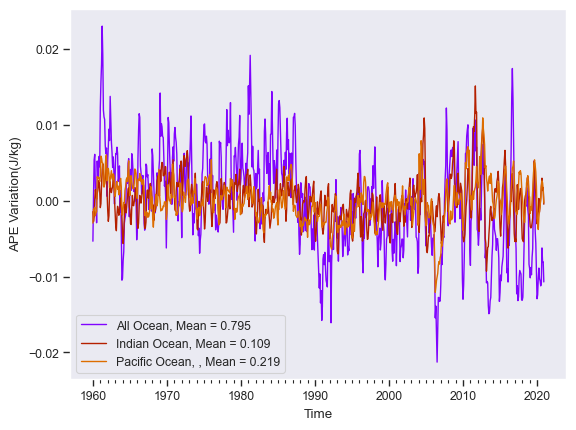

In [17]:
plt.plot(range(ncounter),APE_mean_time_series-APE_mean_time_series.mean(),linewidth=1,label=f'All Ocean, Mean = {np.round(APE_mean_time_series.mean(),3)}')
plt.plot(range(ncounter),APE_IO_mean_time_series-APE_IO_mean_time_series.mean(),linewidth=1,label=f'Indian Ocean, Mean = {np.round(APE_IO_mean_time_series.mean(),3)}')
plt.plot(range(ncounter),APE_PO_mean_time_series-APE_PO_mean_time_series.mean(),linewidth=1,label=f'Pacific Ocean, , Mean = {np.round(APE_PO_mean_time_series.mean(),3)}')
#plt.gca().set_ylim(3.38,3.47)
#plt.gca().invert_yaxis()
plt.legend(loc='best')
plt.ylabel('APE Variation(J/kg)')
plt.xlabel('Time') 
# plt.title()
plt.xticks(np.arange(0, ncounter, 120), labels = np.arange(start_year, end_year+1, 10))
plt.xticks(ticks=np.arange(0, ncounter, 12), labels=None, minor=True)
plt.savefig(f'APE_oceans.pdf', bbox_inches = 'tight')

plt.show()

In [ ]:
plt.plot(range(ncounter),CT_mean_time_series,'r',linewidth=1,label='CT')
plt.plot(range(ncounter),PT_mean_time_series,'b',linewidth=1,label='PT')
plt.plot(range(ncounter),CTR_mean_time_series,'g',linewidth=1,label='CTR') 
# plt.gca().set_ylim(3.38,3.47)
#plt.gca().invert_yaxis()
plt.legend(loc='best')
plt.ylabel('Temperature Variation($^\circ C$)')
plt.xlabel('Time') 
plt.xticks(np.arange(0, ncounter, 120), labels = np.arange(start_year, end_year+1, 10))
plt.xticks(ticks=np.arange(0, ncounter, 12), labels=None, minor=True)
plt.show()

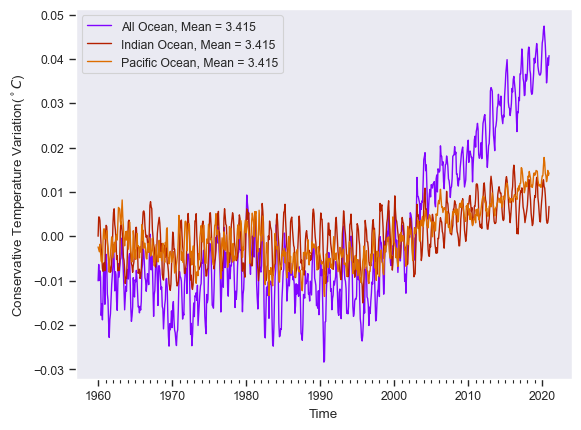

In [19]:
plt.plot(range(ncounter),CT_mean_time_series-CT_mean_time_series.mean(),linewidth=1,label=f'All Ocean, Mean = {np.round(CT_mean_time_series.mean(),3)}')
plt.plot(range(ncounter),CT_IO_mean_time_series-CT_IO_mean_time_series.mean(),linewidth=1,label=f'Indian Ocean, Mean = {np.round(CT_mean_time_series.mean(),3)}')
plt.plot(range(ncounter),CT_PO_mean_time_series-CT_PO_mean_time_series.mean(),linewidth=1,label=f'Pacific Ocean, Mean = {np.round(CT_mean_time_series.mean(),3)}')
plt.legend(loc='best')
plt.ylabel('Conservative Temperature Variation($^\circ C$)')
plt.xlabel('Time') 
plt.xticks(np.arange(0, ncounter, 120), labels = np.arange(start_year, end_year+1, 10))
plt.xticks(ticks=np.arange(0, ncounter, 12), labels=None, minor=True)
# plt.show()
plt.savefig(f'Temp_oceans.pdf', bbox_inches = 'tight')
